# Ultimate Inc. Take Home Challenge
# Michael Phillips

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Part 1 - Exploratory Data Analysis

In [3]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


The dates are recorded as 1970. This is a data quality issue that likely occured when the records were generated or converted to json. I thought this might be a pandas quirk, but 1970 is actually the date listed in the json. With the information available to me, I don't see a way to fix this. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
df['login_time'] = pd.to_datetime(df['login_time'], format='%Y/%m/%d %H:%M:%S')
df.set_index(df['login_time'], inplace=True)
df['count'] = 1
df.head()

,login_time,count
login_time,,
1970-01-01 20:13:18,1970-01-01 20:13:18,1
1970-01-01 20:16:10,1970-01-01 20:16:10,1
1970-01-01 20:16:37,1970-01-01 20:16:37,1
1970-01-01 20:16:36,1970-01-01 20:16:36,1
1970-01-01 20:26:21,1970-01-01 20:26:21,1


In [6]:
df1 = df.resample('15T').sum()

In [7]:
df1 = df1.reset_index()

In [8]:
df1['Date'] = df1['login_time'].dt.date
df1['Time'] = df1['login_time'].dt.time
df1['dayofweek'] = df1['login_time'].dt.dayofweek

df1.head()

,login_time,count,Date,Time,dayofweek
0,1970-01-01 20:00:00,2.0,1970-01-01,20:00:00,3
1,1970-01-01 20:15:00,6.0,1970-01-01,20:15:00,3
2,1970-01-01 20:30:00,9.0,1970-01-01,20:30:00,3
3,1970-01-01 20:45:00,7.0,1970-01-01,20:45:00,3
4,1970-01-01 21:00:00,1.0,1970-01-01,21:00:00,3


In [9]:
pivot_counts = df1.pivot_table(index=['Time'], values=['count'], aggfunc=np.mean)
pivot_counts.head()

,count
Time,
00:00:00,14.107843
00:15:00,15.166667
00:30:00,14.950980
00:45:00,14.529412
01:00:00,15.186275


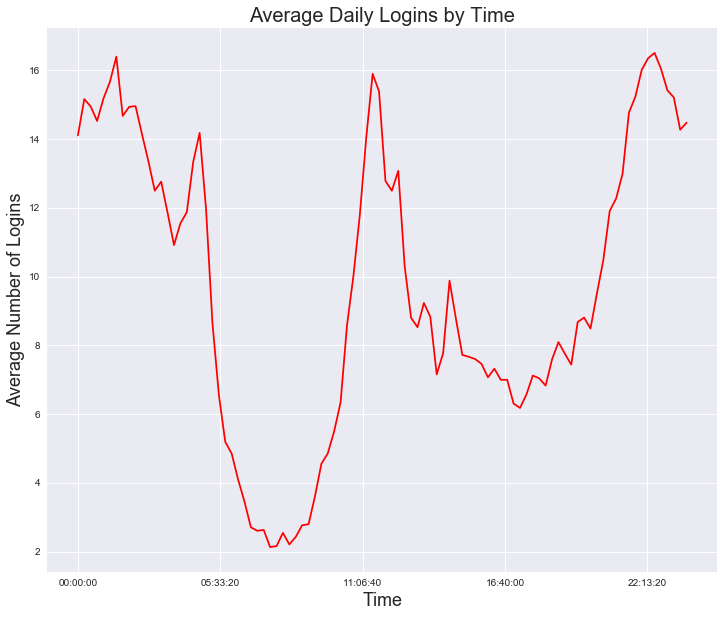

In [10]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes()

ax.plot(pivot_counts, color='red')

plt.title("Average Daily Logins by Time", fontsize=20)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Average Number of Logins", fontsize=18)

The graph above shows the average usage pattern for one day. There is a noticeable dip in user logins during 'working hours', both in the morning and in the afternoon/evening. 

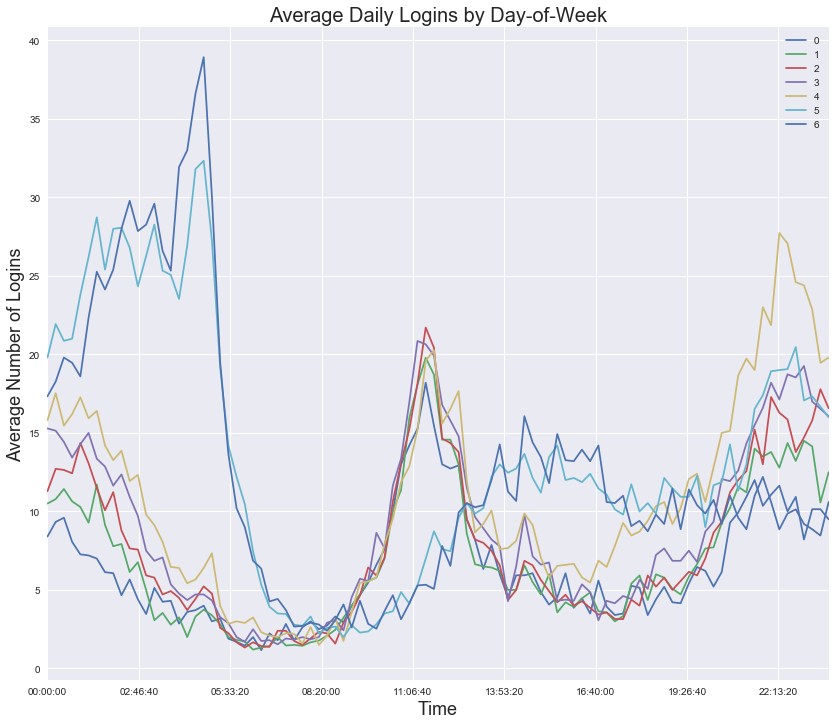

In [12]:
pivoted = pd.pivot_table(df1, values='count', columns='dayofweek', index='Time')


ax = pivoted.plot(figsize=(14,12))


lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.title("Average Daily Logins by Day-of-Week", fontsize=20)
plt.xlabel("Time", fontsize=18)
plt.ylabel("Average Number of Logins", fontsize=18)

For the above graph, monday=0 and Sunday=6. We can see a different usage pattern for weekends compared to weekdays. For weekdays, there is a spike in user logins during the commute, lunchtime, and the evening. For weekends, there is a spike in the mornings, a lull during hte morning, and then steady usage throughout the evening.

# Part 2 - Experiment and Metric Design

### 1.
I would chose a before and after metric to measure the success of the experiment. We could take the percentage of drivers that cross the bridge, and the number of times they do so before the experimental change, and compare that to the rates and numbers after the change. This would give a clear picture of what the baseline numbers looked like, and then what change the experiment potentially had.

### 2.
Presumably, the rates of driver's crossing the toll before any experimental change are known to the company. Therefore, the experiment I would propose would be to offer toll reimbursement to all drivers. This approach will limit the effect of differences between the cities/drivers, and show any effect of the experiment clearly. The drawback is more upfront set-up time to implement/communicate the change to employees. 

Some key metrics pre- and post-experiment can then be looked at: overall percentage of drivers that use the toll vs. those that don't and a driver-by-driver analysis of toll usage to see what effect the experiment had.

### 3.
The experiment could be communicated as a special discount from the city, or other 'limited-time offer'. After that, it would simply be a matter of implementing a way to pay drivers for the toll, and to obtain metrics to see what effect the change was having.

### 4. 
In this experiment, the full populations are known - they are the size of the driver pools. Therefore, I would use a two-sample z-test to test for statistical significance, with one sample being the toll-usage metrics from before the experiment began, and the other being the metrics from after the experiment. 

### 5. 
I would provide the results of the z-test to the city operations team regardless of whether or not the results proved to be significant. From the description provided there is not enough information to make any sort of further recommendation - the description doesn't say **why** the company is interested in pursuing this experiment.

Some important questions the ops team will need to consider:

- What is the additional cost to the company for paying tolls?
- Does the change affect average pick-up times for customers (assuming drivers can get to customers faster if they cross the toll)?
- Does the change allow drivers to fit more trips into their shifts, making more money for the driver and the company?
- Did the experiment cause any other changes, not apparent from raw data? Interviews with drivers would be beneficial.


# Part 3 - Predictive Modeling

In [14]:
import json
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [15]:
print(df['signup_date'].min())
print(df['signup_date'].max())

2014-01-01
2014-01-31


In [16]:
print(df['last_trip_date'].min())
print(df['last_trip_date'].max())

2014-01-01
2014-07-01


In [17]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], format='%Y-%m-%d')
df['signup_date'] = pd.to_datetime(df['signup_date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [18]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [19]:
def is_retained(date):
    
    start = pd.to_datetime('2014-6-1')
    end = pd.to_datetime('2014-7-1')
    if date <= end and date >= start:
        return 1
    else:
        return 0

In [20]:
df['retained_user'] = df['last_trip_date'].apply(is_retained)

In [21]:
(df.retained_user.sum()) / len(df)

0.37608

37.61% of users were 'retained' according to the metrics described in the notes.

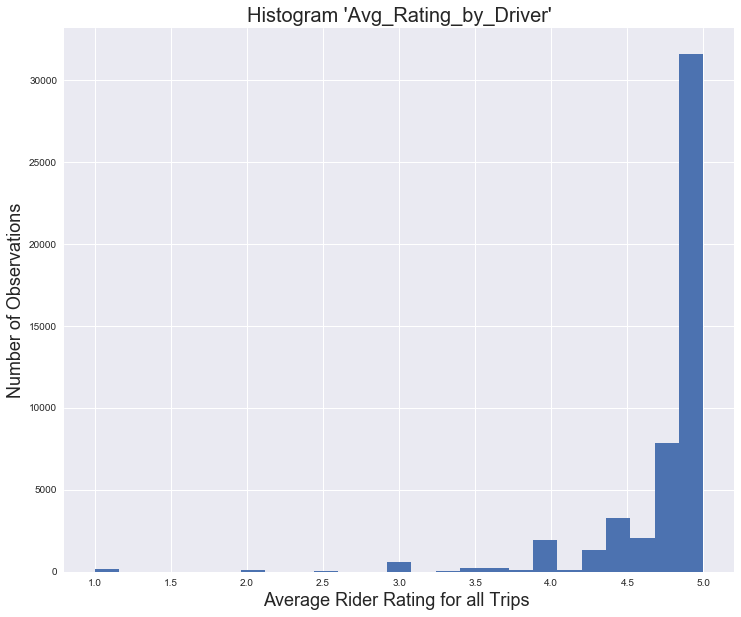

In [25]:
df.hist(column='avg_rating_by_driver', bins=25, figsize=(12,10))
plt.title("Histogram 'Avg_Rating_by_Driver'", fontsize=20)
plt.xlabel("Average Rider Rating for all Trips ", fontsize=18)
plt.ylabel("Number of Observations", fontsize=18)

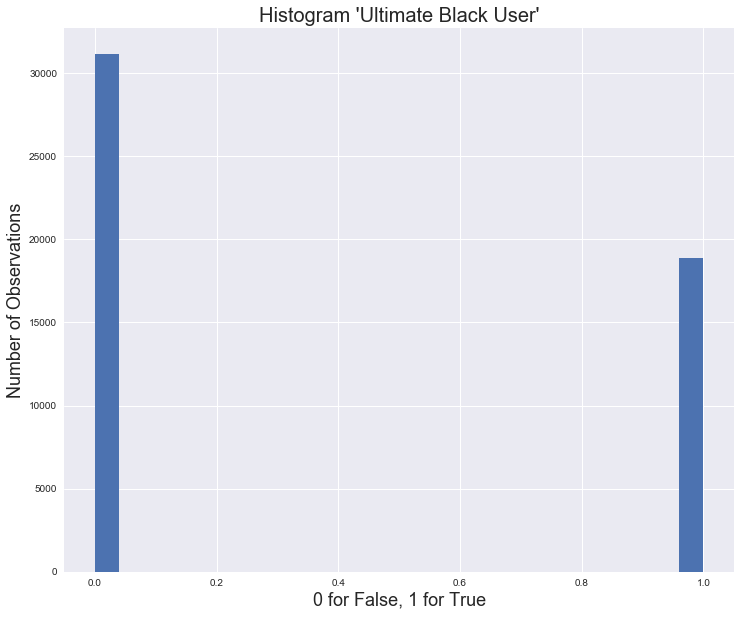

In [28]:
df.hist(column='ultimate_black_user', bins=25, figsize=(12,10))
plt.title("Histogram 'Ultimate Black User'", fontsize=20)
plt.xlabel("0 for False, 1 for True", fontsize=18)
plt.ylabel("Number of Observations", fontsize=18)

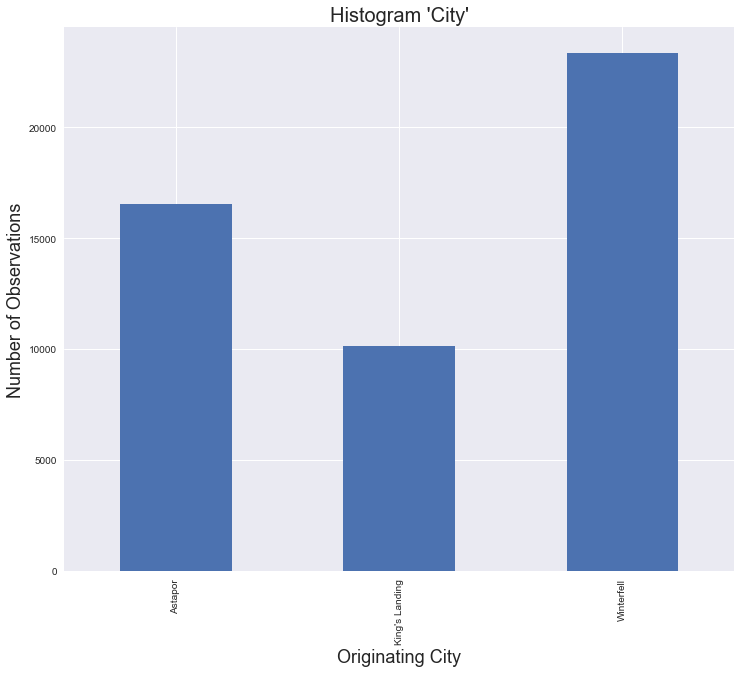

In [30]:
pivot_counts = df.groupby(['city']).count()
pivot_counts['avg_dist'].plot(kind='bar', figsize=(12,10))
plt.title("Histogram 'City'", fontsize=20)
plt.xlabel("Originating City", fontsize=18)
plt.ylabel("Number of Observations", fontsize=18)

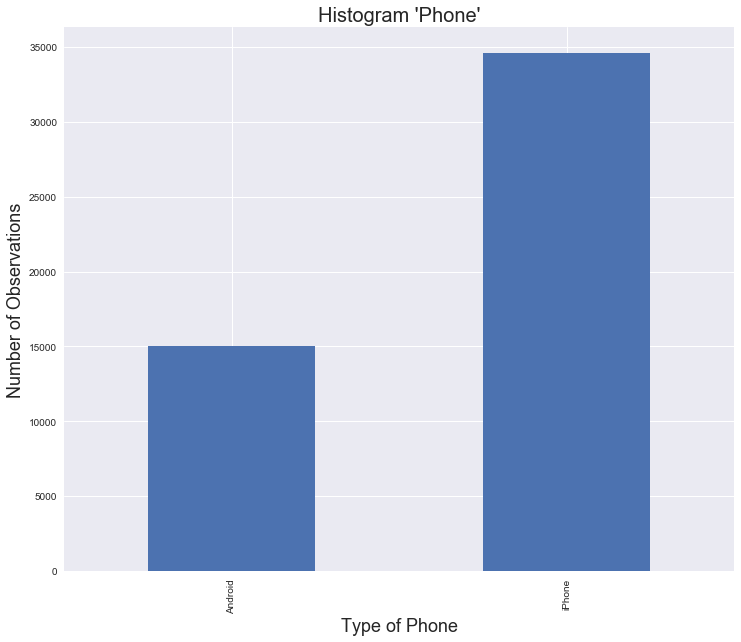

In [31]:
pivot_counts = df.groupby(['phone']).count()
pivot_counts['avg_dist'].plot(kind='bar', figsize=(12,10))
plt.title("Histogram 'Phone'", fontsize=20)
plt.xlabel("Type of Phone", fontsize=18)
plt.ylabel("Number of Observations", fontsize=18)

In [23]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained_user
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [24]:
df.drop('last_trip_date', axis=1, inplace=True)
df.drop('signup_date', axis=1, inplace=True)

In [25]:
def city_map(city):
    if city == "King's Landing":
        return 1
    elif city == "Astapor":
        return 2
    elif city == "Winterfell":
        return 3    

In [26]:
df['city'] = df['city'].apply(city_map)

In [27]:
def phone_map(phone):
    if phone == "iPhone":
        return 1
    elif phone == "Android":
        return 2

In [28]:
df['phone'] = df['phone'].apply(phone_map)

In [29]:
def ultimate_user(user):
    if user == True:
        return 1
    elif user == False:
        return 2

In [30]:
df['ultimate_black_user'] = df['ultimate_black_user'].apply(ultimate_user)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained_user
0,3.67,5.0,4.7,1.10,1,1.0,15.4,4,1,46.2,1
1,8.26,5.0,5.0,1.00,2,2.0,0.0,0,2,50.0,0
2,0.77,5.0,4.3,1.00,2,1.0,0.0,3,2,100.0,0
3,2.36,4.9,4.6,1.14,1,1.0,20.0,9,1,80.0,1
4,3.13,4.9,4.4,1.19,3,2.0,11.8,14,2,82.4,0


In [31]:
df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
phone                      396
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
retained_user                0
dtype: int64

In [32]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)

In [33]:
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna(0, inplace=True)

In [34]:
y = df['retained_user']
df.drop('retained_user', axis=1, inplace=True)

X = df.values

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy import stats

In [36]:
sss = StratifiedShuffleSplit(test_size=0.25)
sss.get_n_splits(X,y)

10

In [37]:
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# create classifier and parameter dict for gridsearch
clf = RandomForestClassifier(n_jobs=-1,random_state=20)

parameters = {'n_estimators':[15,20,30,32,40],
              'max_features':['auto', 'sqrt', 'log2'],
              'min_samples_split':[5,10,20,30,40]}

In [38]:
from sklearn.model_selection import GridSearchCV

# use gridsearch to find best parameters
CV_rfc = GridSearchCV(estimator=clf, param_grid=parameters, cv=sss)
CV_rfc.fit(X_train,y_train)

# create new classifier from best parameters
rfc = CV_rfc.best_estimator_

#predict from test set
pred = rfc.predict(X_test)

from sklearn.metrics import classification_report

# use class values to see how the model performed
print(classification_report(y_test, pred))
acc_score = (accuracy_score(y_test, pred) * 100)
print("The model predicts %.2f%% of users correctly." % acc_score)


             precision    recall  f1-score   support

          0       0.80      0.86      0.83      7799
          1       0.74      0.65      0.69      4701

avg / total       0.78      0.78      0.78     12500

The model predicts 78.17% of the games it tests correctly.


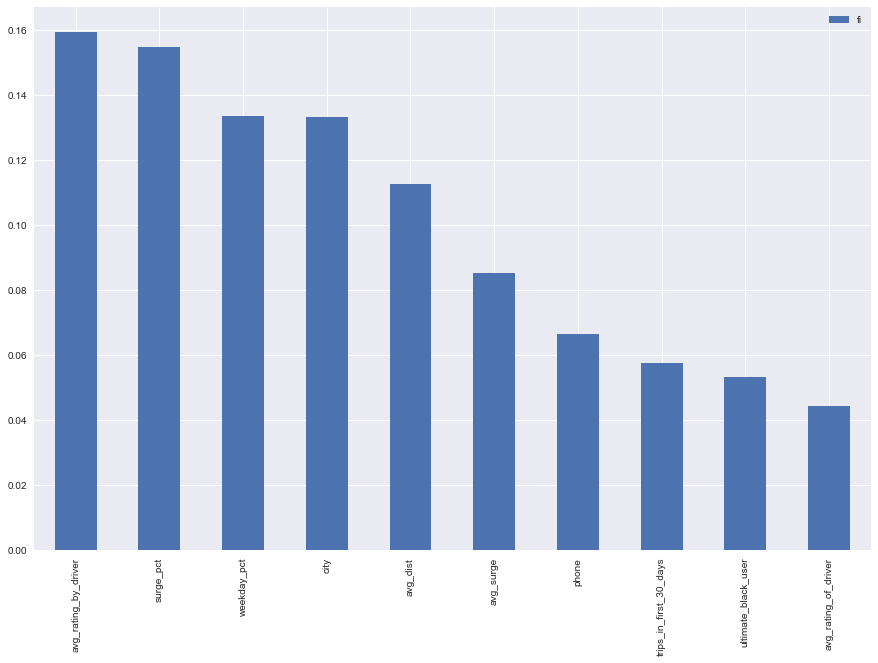

In [40]:
fi = rfc.feature_importances_
fi_df = pd.DataFrame({'fi':fi})

fi_names = list(df.columns.values)
fi_names_df = pd.DataFrame({'fi_names':fi_names})

fi_imp = fi_names_df.join(fi_df)
fi_imp = fi_imp.sort_values(by='fi',ascending=False)
fi_imp.reset_index(drop=True,inplace=True)
import matplotlib.pyplot as plt
%matplotlib inline
ax = fi_imp.plot(kind='bar',figsize=(15,10))
ax.set_xticklabels(fi_imp.fi_names);